In [147]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
from tensorflow import keras
import time
import matplotlib.pyplot as plt


Tarea 1A: DecisionStump y ADABoost Binario sin mejoras

In [148]:
import numpy as np

def balance_training_dataset(digit, X_train, y_train):
    target_indices = np.where(y_train == digit)[0] # Obtiene los indices de las muestras que corresponden al digito objetivo
    num_target_samples = len(target_indices) # Obtiene el numero de muestras del digito objetivo

    num_samples_per_other_digit = num_target_samples // 9 # Obtiene el numero de muestras por cada otro digito

    X_train_balanced = [] # Crea una lista vacia para almacenar los datos de entrenamiento balanceados
    y_train_balanced = [] # Crea una lista vacia para almacenar las etiquetas de entrenamiento balanceadas

    X_train_balanced.extend(X_train[target_indices]) # Agrega todas las muestras del digito objetivo a los datos de entrenamiento balanceados
    y_train_balanced.extend(y_train[target_indices]) # Agrega todas las etiquetas del digito objetivo a las etiquetas de entrenamiento balanceadas


    for i in range(10):  # Itera sobre todos los digitos
        if i == digit: # Si el digito es el objetivo
            continue  # Continua con la siguiente iteracion
        indices = np.where(y_train == i)[0] # Obtiene los indices de las muestras que corresponden al digito actual
        if len(indices) >= num_samples_per_other_digit: # Si el numero de muestras del digito actual es mayor o igual al numero de muestras por cada otro digito
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=False) # Selecciona aleatoriamente el numero de muestras por cada otro digito sin reemplazo
        else:
            balanced_indices = np.random.choice(indices, num_samples_per_other_digit, replace=True) # Selecciona aleatoriamente el numero de muestras por cada otro digito con reemplazo
        X_train_balanced.extend(X_train[balanced_indices]) # Agrega las muestras seleccionadas a los datos de entrenamiento balanceados
        y_train_balanced.extend([i] * num_samples_per_other_digit) # Agrega las etiquetas del digito actual a las etiquetas de entrenamiento balanceadas


    X_train_balanced = np.array(X_train_balanced) # convierte los datos de entrenamiento balanceados a un arreglo de numpy
    y_train_balanced = np.array(y_train_balanced) # convierte las etiquetas de entrenamiento balanceadas a un arreglo de numpy


    y_train_binary_balanced = np.where(y_train_balanced == digit, 1, -1) # convierte las etiquetas de entrenamiento balanceadas a etiquetas binarias

    shuffle_indices = np.random.permutation(len(X_train_balanced)) # obtiene indices aleatorios para hacer una mezcla de los datos de entrenamiento balanceados
    X_train_balanced = X_train_balanced[shuffle_indices] # mezcla los datos de entrenamiento balanceados
    y_train_binary_balanced = y_train_binary_balanced[shuffle_indices] # mezcla las etiquetas de entrenamiento balanceadas

    return X_train_balanced, y_train_binary_balanced # retorna los datos de entrenamiento balanceados y las etiquetas de entrenamiento balanceadas

In [149]:

import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    if verboseParam:
        print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    if verboseParam:
        print(f"Accuracy for digit {digit}: {accuracy:.4f}") # Mostramos la precisión

    return y_test_binary, np.sign(y_pred), accuracy # Devolvemos las etiquetas verdaderas, las predicciones, y la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    all_true_labels = [] # Inicializamos las etiquetas verdaderas
    all_pred_labels = [] # Inicializamos las predicciones
    accuracies = {} # Inicializamos las precisiones

    for digit in range(10): # Para cada dígito
        y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        all_true_labels.extend(y_test_binary) # Guardamos las etiquetas verdaderas
        all_pred_labels.extend(y_pred) # Guardamos las predicciones
        accuracies[digit] = accuracy # Guardamos la precisión

        if verboseParam: # Si verboseParam es True
            print(f"Confusion Matrix for digit {digit}:") # Mostramos la matriz de confusión para cada dígito
            print_confusion_matrix(y_test_binary, y_pred) # Mostramos la matriz de confusión para cada dígito

    if verboseParam: # Si verboseParam es True
        print("Overall Confusion Matrix:") # Mostramos la matriz de confusión general
        print_confusion_matrix(all_true_labels, all_pred_labels) # Mostramos la matriz de confusión general

    return accuracies # Devolvemos las precisiones


def print_confusion_matrix(true_labels, pred_labels): # Creamos la función para mostrar la matriz de confusión
    num_classes = 2 # Número de clases (1 y -1)
    matrix = np.zeros((num_classes, num_classes), dtype=int) # Inicializamos la matriz de confusión

    for t, p in zip(true_labels, pred_labels): # Para cada par de etiquetas verdaderas y predicciones
        matrix[int((t + 1) / 2), int((p + 1) / 2)] += 1 # Actualizamos la matriz de confusión

    print(matrix) # Imprimimos la matriz de confusión

In [158]:
accuracy = run_adaboost_on_mnist(digit=0, T=50, A=20, verboseParam=False)  # Ejecutamos AdaBoost
print("accuracy for this digit: " + str(accuracy[2])) # Mostramos la precisión

accuracy for this digit: 0.9562


In [ ]:
#Paara ver las matrices de confusión de cada dígito, poner verboseParam=True
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=False) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Accuracies for all digits: {0: 0.9565, 1: 0.9624, 2: 0.8992, 3: 0.8887, 4: 0.9116, 5: 0.8734, 6: 0.9458, 7: 0.9464, 8: 0.8717, 9: 0.8623}


Tarea 1B: Experimentación con los parámetros T y A del método AdaboostBinario.predict

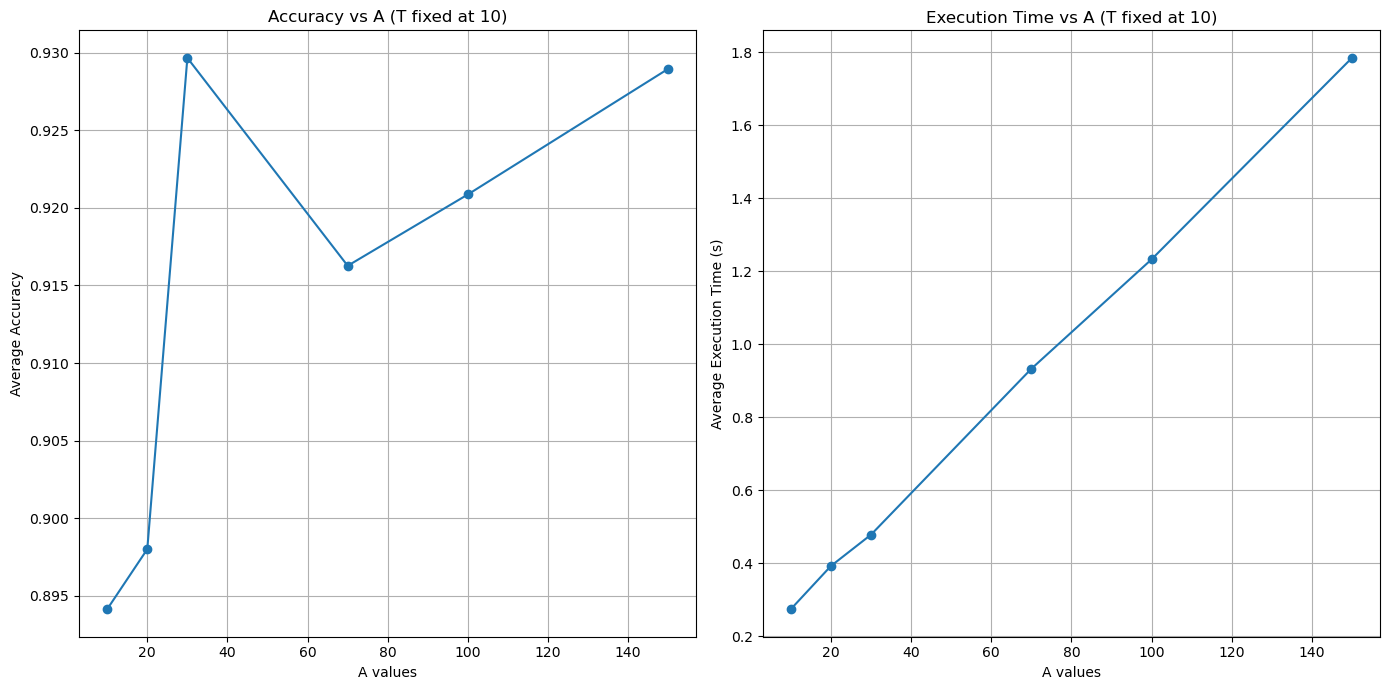

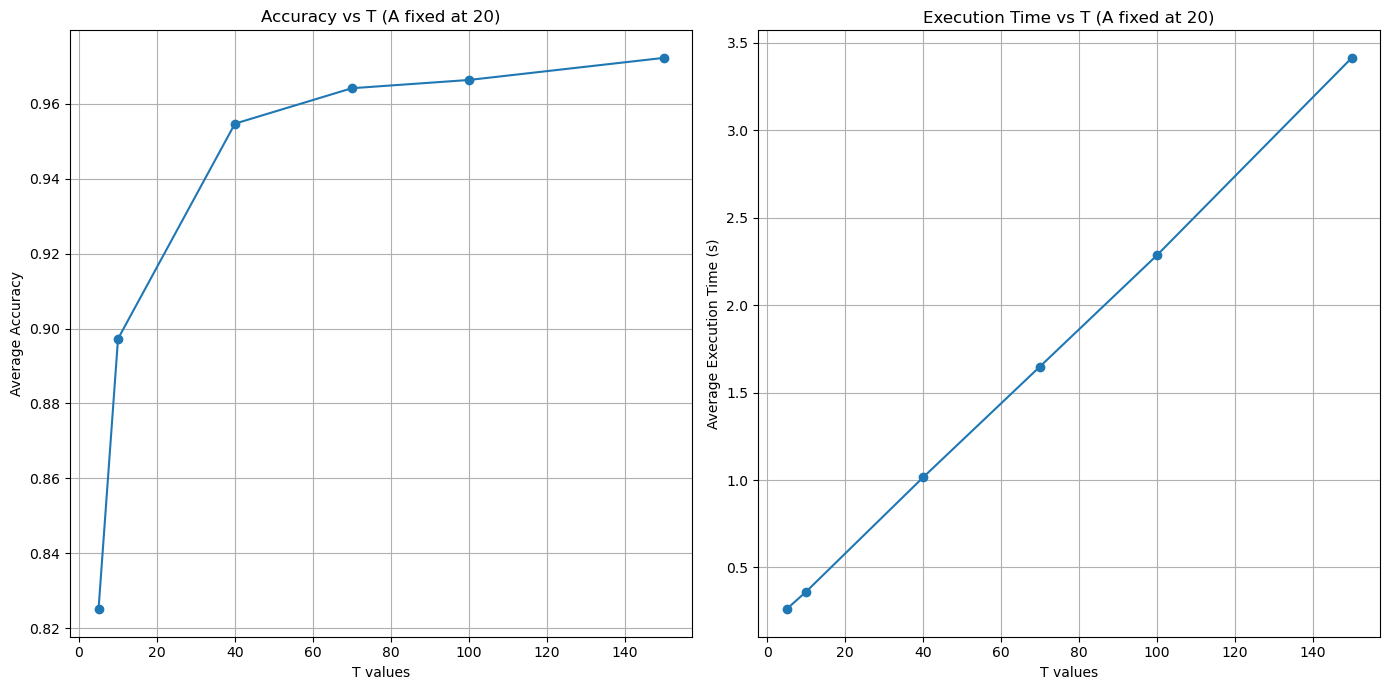

In [160]:
def experiment_adaboost_fixed_T(T_fixed, A_values, repetitions=3, verboseParam=False):
    accuracies = []
    execution_times = []

    for A in A_values:
        acc = []
        exec_time = []
        for _ in range(repetitions):
            start_time = time.time()
            y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit=0, T=T_fixed, A=A, verboseParam=verboseParam)
            end_time = time.time()
            
            acc.append(accuracy)
            exec_time.append(end_time - start_time)

        avg_accuracy = np.mean(acc)
        avg_execution_time = np.mean(exec_time)
        accuracies.append(avg_accuracy)
        execution_times.append(avg_execution_time)

    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs A (T fixed at {T_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, execution_times, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs A (T fixed at {T_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def experiment_adaboost_fixed_A(A_fixed, T_values, repetitions=3, verboseParam=False):
    accuracies = []
    execution_times = []

    for T in T_values:
        acc = []
        exec_time = []
        for _ in range(repetitions):
            start_time = time.time()
            y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit=0, T=T, A=A_fixed, verboseParam=verboseParam)
            end_time = time.time()

            acc.append(accuracy)
            exec_time.append(end_time - start_time)

        avg_accuracy = np.mean(acc)
        avg_execution_time = np.mean(exec_time)
        accuracies.append(avg_accuracy)
        execution_times.append(avg_execution_time)

    # Plotting results
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs T (A fixed at {A_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, execution_times, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs T (A fixed at {A_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    T_fixed = 10
    A_values = [10, 20, 30, 70, 100, 150]

    experiment_adaboost_fixed_T(T_fixed, A_values, repetitions=5, verboseParam=False)

    A_fixed = 20
    T_values = [5, 10, 40, 70, 100, 150]

    experiment_adaboost_fixed_A(A_fixed, T_values, repetitions=5, verboseParam=False)


Tareas 1C: ADABoost Multiclase

In [163]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, img_shape): # Inicializamos la clase
        self.feature_index = (np.random.randint(0, img_shape[0]), np.random.randint(0, img_shape[1])) # Elegimos un índice de característica aleatorio en 2D
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.img_shape = img_shape # Inicializamos la forma de la imagen
        self.alpha = None # Inicializamos el alpha

    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index[0], self.feature_index[1]] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, img_rows, img_cols = X.shape # Obtenemos el número de muestras y el tamaño de la imagen
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump((img_rows, img_cols)) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index[0], clf.feature_index[1]]), max(X[:, clf.feature_index[0], clf.feature_index[1]])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_on_mnist
    if verboseParam:
        print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    if verboseParam:
        print(f"Accuracy for digit {digit}: {accuracy:.4f}") # Mostramos la precisión

    return y_test_binary, np.sign(y_pred), accuracy # Devolvemos las etiquetas verdaderas, las predicciones, y la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    all_true_labels = [] # Inicializamos las etiquetas verdaderas
    all_pred_labels = [] # Inicializamos las predicciones
    accuracies = {} # Inicializamos las precisiones

    for digit in range(10): # Para cada dígito
        y_test_binary, y_pred, accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        all_true_labels.extend(y_test_binary) # Guardamos las etiquetas verdaderas
        all_pred_labels.extend(y_pred) # Guardamos las predicciones
        accuracies[digit] = accuracy # Guardamos la precisión

        if verboseParam: # Si verboseParam es True
            print(f"Confusion Matrix for digit {digit}:") # Mostramos la matriz de confusión para cada dígito
            print_confusion_matrix(y_test_binary, y_pred) # Mostramos la matriz de confusión para cada dígito

    if verboseParam: # Si verboseParam es True
        print("Overall Confusion Matrix:") # Mostramos la matriz de confusión general
        print_confusion_matrix(all_true_labels, all_pred_labels) # Mostramos la matriz de confusión general

    return accuracies # Devolvemos las precisiones


def print_confusion_matrix(true_labels, pred_labels): # Creamos la función para mostrar la matriz de confusión
    num_classes = 2 # Número de clases (1 y -1)
    matrix = np.zeros((num_classes, num_classes), dtype=int) # Inicializamos la matriz de confusión

    for t, p in zip(true_labels, pred_labels): # Para cada par de etiquetas verdaderas y predicciones
        matrix[int((t + 1) / 2), int((p + 1) / 2)] += 1 # Actualizamos la matriz de confusión

    print(matrix) # Imprimimos la matriz de confusión

In [166]:
accuracy = run_adaboost_on_mnist(digit=0, T=50, A=20, verboseParam=False)  # Ejecutamos AdaBoost
print("accuracy for this digit: " + str(accuracy[2])) # Mostramos la precisión

accuracy for this digit: 0.9595


In [167]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=50, verboseParam=False) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Accuracies for all digits: {0: 0.9617, 1: 0.9653, 2: 0.9218, 3: 0.8882, 4: 0.9069, 5: 0.8695, 6: 0.9518, 7: 0.9345, 8: 0.8709, 9: 0.8632}


In [170]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X, y)
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X_train_balanced, Y_train_binary_balanced, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, graph_param=False): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass

    y_pred = np.zeros_like(y_test) # Inicializamos las predicciones
    
    confusion_matrix = np.zeros((10, 10), dtype=int)  # Initialize confusion matrix

    for digit, model in enumerate(adaboost_multiclass.models): # Para cada dígito y modelo
        y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias
        model_pred = model.predict(X_test) # Realizamos las predicciones
        y_pred[y_test == digit] = digit # Si la etiqueta es el dígito, la predicción es el dígito
        y_pred[y_test != digit] = np.argmax([model.predict(X_test) for model in adaboost_multiclass.models], axis=0)[y_test != digit] # Si la etiqueta no es el dígito, la predicción es el índice del valor máximo
         
        # Update confusion matrix
        for t, p in zip(y_test, y_pred): # For each true and predicted label
            confusion_matrix[t, p] += 1 # Update confusion matrix
        
        if verboseParam: # Si verboseParam es True
            print(f"Confusion Matrix for digit {digit}:") # Mostramos la matriz de confusión para cada dígito
            print_confusion_matrix(y_test_binary, np.sign(model_pred)) # Mostramos la matriz de confusión para cada dígito

    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    if graph_param == False: # Si graph_param es False
        print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    
    # Print overall confusion matrix
    if graph_param == False:
        print("Overall Multiclass Confusion Matrix:") # Mostramos la matriz de confusión general
        print(confusion_matrix) # Imprimimos la matriz de confusión general

    return accuracy # Devolvemos la precisión




In [146]:
accuracy = run_adaboost_multiclass_on_mnist(T=50, A=20, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.8601
Overall Multiclass Confusion Matrix:
[[ 9359     0    36    36     9   135   126    18    45    36]
 [    0 10873   108    36     0    45    36     0   252     0]
 [  144   297  8124   324   279    72   243   216   585    36]
 [   99    90   243  8408    45   567    45   162   279   162]
 [   45    45    99    27  8353   126   117    63   207   738]
 [  234   144   108   711   261  6544   207   189   270   252]
 [  135    45   162    27   189   189  8689    18   117     9]
 [   36   225   198    36   207    63     9  8921    18   567]
 [  126   153   108   450    99   261   108   126  8048   261]
 [   99    72    54   117   702   171     9   441   225  8200]]


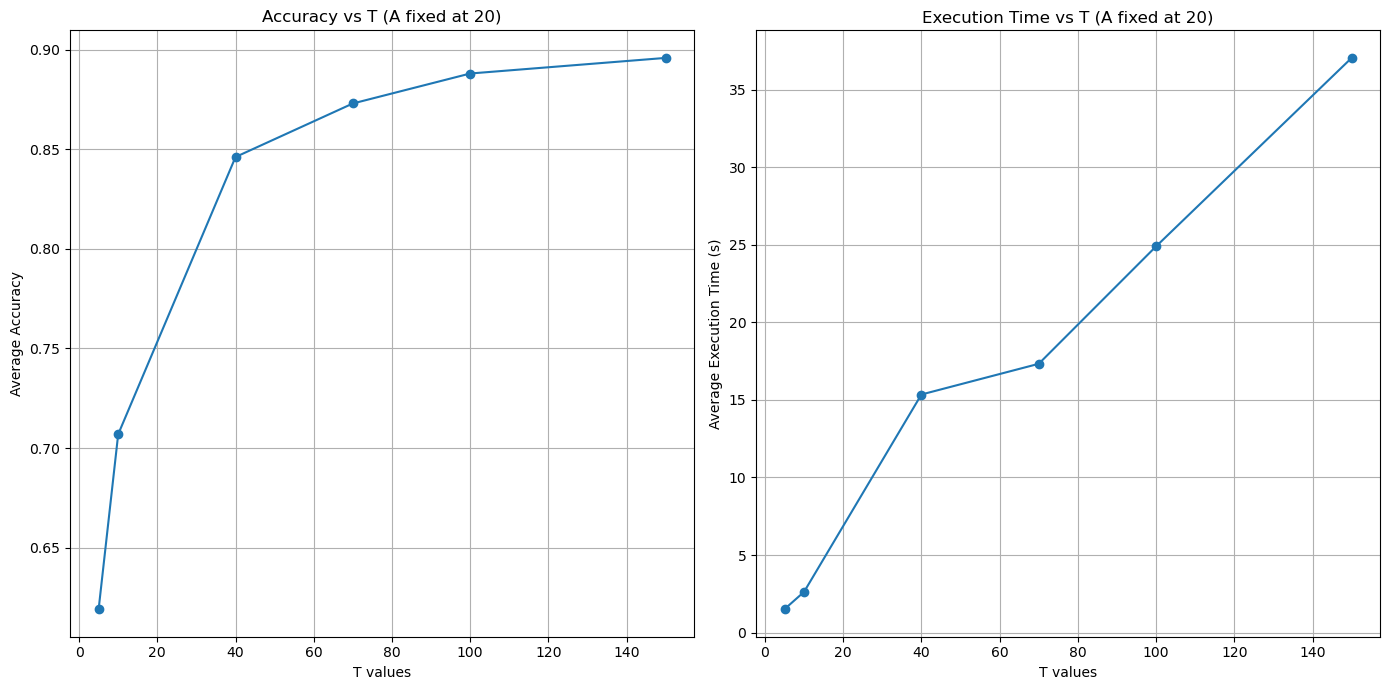

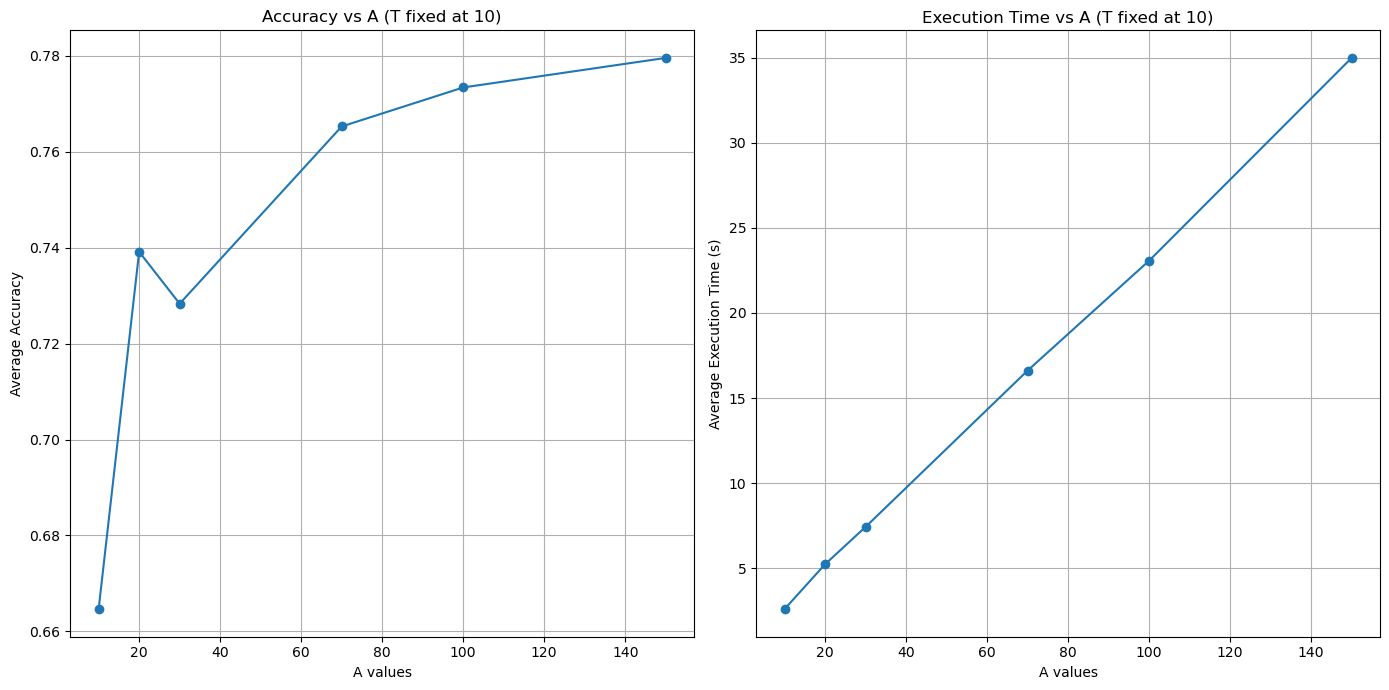

In [171]:
import matplotlib.pyplot as plt
import time
import numpy as np

def graph_experimentation_for_task_1C(number_of_reps):
    T_values = [5, 10, 40, 70, 100, 150]
    A_values = [10, 20, 30, 70, 100, 150]
    A_fixed = 20
    T_fixed = 10

    def run_experiment(T, A):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_multiclass_on_mnist(T=T, A=A, verboseParam=False,
                                                        graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 10)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 10)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 5
    graph_experimentation_for_task_1C(number_of_reps)


TAREA 1D

ADABoost Binario con mejoras gracias a la aplicación de PCA (Principal Analysis component)

In [188]:
import numpy as np # Importamos la librería numpy
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else:
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de características máximas a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, verbose=False): # Creamos la función fit
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        for t in range(self.T): # Para cada iteración
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): # Para cada clasificador débil
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w) # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil

            if verbose: # Si verbose es True
                print(f'Classifier {t + 1}/{self.T}: error = {min_error}, alpha = {best_clf.alpha}') # Mostramos el error y el alpha

    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_PCA(X, n_components): # Creamos la función apply_PCA
    X_mean = np.mean(X, axis=0) # Calculamos la media
    X_centered = X - X_mean # Centramos los datos
    covariance_matrix = np.cov(X_centered, rowvar=False) # Calculamos la matriz de covarianza
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix) # Calculamos los autovalores y autovectores
    sorted_index = np.argsort(eigenvalues)[::-1] # Ordenamos los índices de los autovalores de mayor a menor
    sorted_eigenvectors = eigenvectors[:, sorted_index] # Ordenamos los autovectores
    eigenvector_subset = sorted_eigenvectors[:, 0:n_components] # Seleccionamos los autovectores
    X_reduced = np.dot(X_centered, eigenvector_subset) # Reducimos la dimensionalidad
    return X_reduced, eigenvector_subset, X_mean # Devolvemos los datos reducidos, los autovectores seleccionados y la media

def balance_training_dataset(digit, X_train, y_train): # Creamos la función balance_training_dataset
    digit_indices = np.where(y_train == digit)[0] # Obtenemos los índices del dígito
    non_digit_indices = np.where(y_train != digit)[0] # Obtenemos los índices de los no dígitos

    np.random.shuffle(non_digit_indices) # Barajamos los índices de los no dígitos
    non_digit_indices = non_digit_indices[:len(digit_indices)] # Seleccionamos los índices de los no dígitos

    balanced_indices = np.concatenate([digit_indices, non_digit_indices]) # Concatenamos los índices balanceados
    np.random.shuffle(balanced_indices) # Barajamos los índices balanceados

    X_train_balanced = X_train[balanced_indices] # Obtenemos los datos balanceados
    y_train_balanced = y_train[balanced_indices] # Obtenemos las etiquetas balanceadas
    y_train_binary_balanced = np.where(y_train_balanced == digit, 1, -1) # Convertimos las etiquetas a binarias
 
    return X_train_balanced, y_train_binary_balanced # Devolvemos los datos balanceados y las etiquetas balanceadas

def run_adaboost_on_mnist(digit, T=5, A=20, n_components=None, verboseParam=False, graph_param=False): # Creamos la función run_adaboost_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train) # Convertimos las etiquetas a binarias
    X_train_balanced = X_train_balanced.reshape(X_train_balanced.shape[0], -1) # Aplanamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos

    if n_components is not None: # Si n_components no es None
        X_train_balanced, eigenvector_subset, X_mean = apply_PCA(X_train_balanced, n_components) # Reducimos la dimensionalidad de los datos de entrenamiento
        X_test = (X_test - X_mean).dot(eigenvector_subset) # Reducimos la dimensionalidad de los datos de prueba

    adaboost = AdaBoost(T=T, A=A) # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_balanced, Y_train_binary_balanced, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, n_components=None, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, n_components, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy    # Guardamos la precisión
    return accuracies # Devolvemos las precisiones


In [184]:
accuracy = run_adaboost_on_mnist(digit=0, T=50, A=20, n_components=50, verboseParam=False)  # Ejecutamos AdaBoost
print("accuracy for this digit: " + str(accuracy)) # Mostramos la precisión

Running AdaBoost for digit: 0
Accuracy for digit 0: 0.9674
accuracy for this digit: 0.9674


In [190]:
all_accuracies = run_adaboost_for_all_digits(T=50, A=20, n_components=50, verboseParam=False) # Ejecutamos AdaBoost para todos los dígitos
print("Accuracies for all digits:", all_accuracies) # Imprimimos las precisiones

Accuracies for all digits: {0: 0.97, 1: 0.9755, 2: 0.9079, 3: 0.8842, 4: 0.8953, 5: 0.8641, 6: 0.9403, 7: 0.9413, 8: 0.8409, 9: 0.8649}


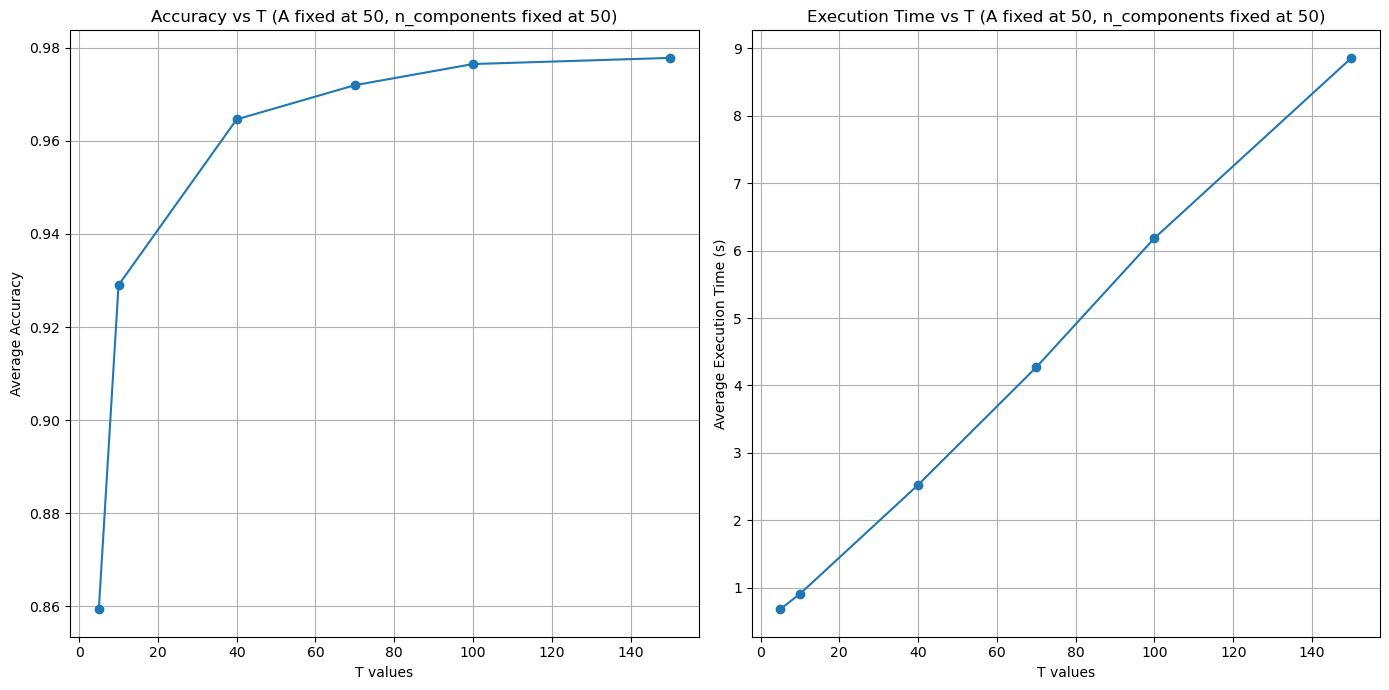

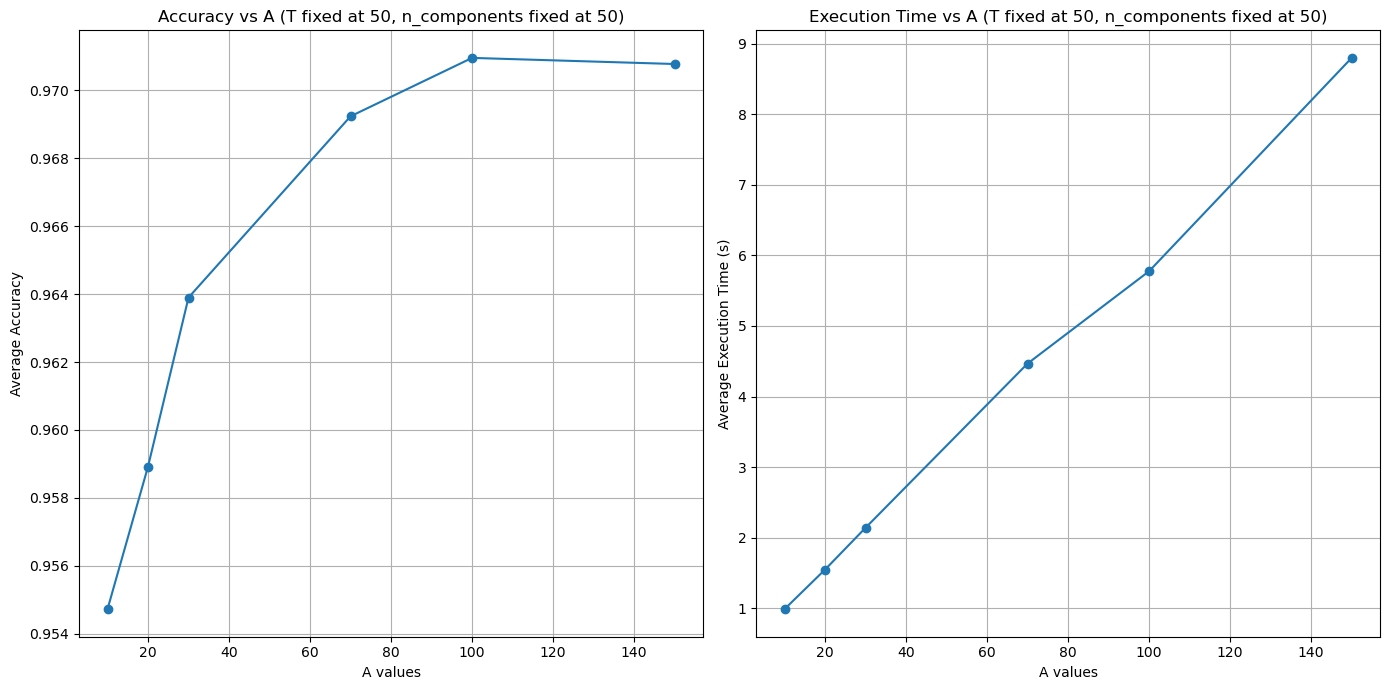

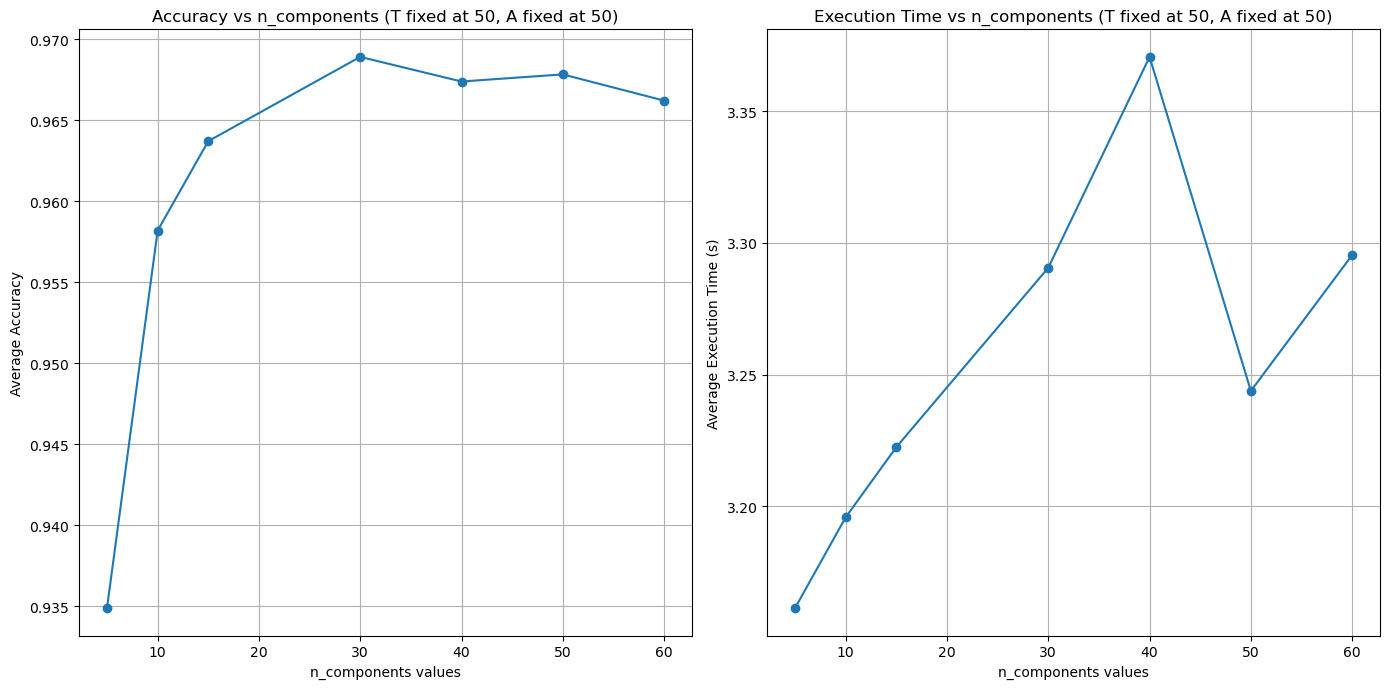

In [194]:
def graph_experimentation_for_task_1D(number_of_reps, digit):
    T_values = [5, 10, 40, 70, 100, 150]
    A_values = [10, 20, 30, 70, 100, 150]
    n_components_values = [None, 5, 10, 15, 30, 40, 50, 60]
    A_fixed = 50
    T_fixed = 50
    n_components_fixed = 50

    def run_experiment(T, A, n_components):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_on_mnist(digit, T=T, A=A, n_components=n_components, verboseParam=False, graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)


    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed, n_components_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs T (A fixed at {A_fixed}, n_components fixed at {n_components_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs T (A fixed at {A_fixed}, n_components fixed at {n_components_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A, n_components_fixed)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs A (T fixed at {T_fixed}, n_components fixed at {n_components_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs A (T fixed at {T_fixed}, n_components fixed at {n_components_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    accuracies_n_components = []
    exec_times_n_components = []
    for n_components in n_components_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A_fixed, n_components)
        accuracies_n_components.append(avg_acc)
        exec_times_n_components.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(n_components_values, accuracies_n_components, marker='o')
    plt.xlabel('n_components values')
    plt.ylabel('Average Accuracy')
    plt.title(f'Accuracy vs n_components (T fixed at {T_fixed}, A fixed at {A_fixed})')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(n_components_values, exec_times_n_components, marker='o')
    plt.xlabel('n_components values')
    plt.ylabel('Average Execution Time (s)')
    plt.title(f'Execution Time vs n_components (T fixed at {T_fixed}, A fixed at {A_fixed})')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 5
    digit = 0  
    graph_experimentation_for_task_1D(number_of_reps, digit)

In [197]:
class AdaBoostMulticlass: # Creamos la clase AdaBoostMulticlass
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.models = [] # Inicializamos los modelos

    def fit(self, X, y, verbose=False): # Creamos la función fit
        for digit in range(10): # Para cada dígito
            X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X, y)
            model = AdaBoost(T=self.T, A=self.A) # Creamos el clasificador AdaBoost
            model.fit(X_train_balanced, Y_train_binary_balanced, verbose) # Ajustamos el clasificador AdaBoost
            self.models.append(model) # Añadimos el clasificador AdaBoost

    def predict(self, X): # Creamos la función predict
        model_preds = np.array([model.predict(X) for model in self.models]) # Realizamos las predicciones
        return np.argmax(model_preds, axis=0) # Devolvemos el índice del valor máximo

def run_adaboost_multiclass_on_mnist(T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_multiclass_on_mnist
    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos
    X_train = X_train.reshape(X_train.shape[0], -1) # Redimensionamos los datos
    X_test = X_test.reshape(X_test.shape[0], -1) # Redimensionamos los datos

    # Apply PCA
    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components)

    adaboost_multiclass = AdaBoostMulticlass(T=T, A=A) # Creamos el clasificador AdaBoostMulticlass
    adaboost_multiclass.fit(X_train_reduced, y_train, verboseParam) # Ajustamos el clasificador AdaBoostMulticlass
    y_pred = adaboost_multiclass.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test == y_pred) / len(y_test) # Calculamos la precisión
    print(f"Multiclass Accuracy: {accuracy}") # Mostramos la precisión
    return accuracy # Devolvemos la precisión




In [198]:
accuracy = run_adaboost_multiclass_on_mnist(T=50, A=50, verboseParam=False) # Ejecutamos AdaBoostMulticlass

Multiclass Accuracy: 0.8603


TAREA 1E

In [200]:
import numpy as np  # la libreería numpy sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # importamos el dataset MNIST
from sklearn.decomposition import PCA # importamos Principal Component Analysis

class DecisionStump: # Creamos la clase DecisionStump
    def __init__(self, n_features): # Inicializamos la clase
        self.feature_index = np.random.randint(0, n_features) # Elegimos un índice de característica aleatorio
        self.threshold = None # Inicializamos el umbral
        self.polarity = 1 # Inicializamos la polaridad
        self.n_features = n_features # Inicializamos el número de características
        self.alpha = None # Inicializamos el alpha
        
    def predict(self, X): # Creamos la función predict
        n_samples = X.shape[0] # Obtenemos el número de muestras
        X_column = X[:, self.feature_index] # Obtenemos la columna de la característica
        predictions = np.ones(n_samples) # Inicializamos las predicciones
        if self.polarity == 1: # Si la polaridad es 1
            predictions[X_column < self.threshold] = -1 # Si la columna de la característica es menor que el umbral, la predicción es -1
        else: # Si la polaridad no es 1
            predictions[X_column >= self.threshold] = -1 # Si la columna de la característica es mayor o igual que el umbral, la predicción es -1
        return predictions # Devolvemos las predicciones

class AdaBoost: # Creamos la clase AdaBoost
    def __init__(self, T=5, A=20): # Inicializamos la clase
        self.T = T # Inicializamos el número de clasificadores débiles
        self.A = A # Inicializamos el número de píxeles máximos a probar por clasificador débil
        self.clfs = [] # Inicializamos los clasificadores débiles

    def fit(self, X, Y, X_Verification, Y_Verification, iter_number = 100, 
            verbose=False, round1 = 3, round2 = 3, 
            bestAccuracyBreak = 0.999 ,practicalAccuracyBreak=666,
            graph_param = False): # Creamos la función fit
        bestAccuracy = 0
        newAccuracy = 0
        practicalRepeatAccuracy = 0
        t = 0
        
        n_samples, n_features = X.shape # Obtenemos el número de muestras y el número de características
        w = np.full(n_samples, (1 / n_samples)) # Inicializamos los pesos

        while (True):
            if newAccuracy >= bestAccuracyBreak:
                if graph_param == False:
                    print("Se para el entrenamiento debido a que la precisión ha alcanzado el valor práctico buscado")
                    print(f"El número óptimo de clasificadores débiles es: {len(self.clfs)} ")
                    print(f"La precisión obtenida en el entrenamiento ha sido de: {round(newAccuracy, round2)}")
                break
            
            if practicalRepeatAccuracy == practicalAccuracyBreak:
                if graph_param == False:
                    print("Se para el entrenamiento debido a que la precisión se ha quedado estancada en un intervalo")
                    print("Se para el entrenamiento debido a que la precisión ha alcanzado el valor práctico buscado")
                    print(f"El número óptimo de clasificadores débiles es: {len(self.clfs)} ")
                    print(f"La precisión obtenida en el entrenamiento ha sido de: {round(newAccuracy, round2)}")
                break
            
            if round(newAccuracy, round1) == round(bestAccuracy, round1):
                practicalRepeatAccuracy += 1
            else:
                practicalRepeatAccuracy = 0
                
            bestAccuracy = newAccuracy
            newAccuracy = 0
            t += 1
            
            min_error = float('inf') # Inicializamos el error mínimo
            best_clf = None # Inicializamos el mejor clasificador débil

            for _ in range(self.A): 
                clf = DecisionStump(n_features) # Creamos un clasificador débil
                clf.threshold = np.random.uniform(min(X[:, clf.feature_index]), max(X[:, clf.feature_index])) # Elegimos un umbral aleatorio
                clf.polarity = 1 # Elegimos una polaridad
                predictions = clf.predict(X) # Realizamos las predicciones
                error = np.sum(w[Y != predictions]) # Calculamos el error
                if error > 0.5: # Si el error es mayor que 0.5
                    error = 1 - error # El error es 1 menos el error
                    clf.polarity = -1 # La polaridad es -1

                if error < min_error: # Si el error es menor que el error mínimo
                    min_error = error # El error mínimo es el error
                    best_clf = clf # El mejor clasificador débil es el clasificador débil

            EPS = 1e-10 # Definimos un valor muy pequeño
            best_clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) # Calculamos el alpha
            predictions = best_clf.predict(X) # Realizamos las predicciones
            w *= np.exp(-best_clf.alpha * Y * predictions) # Actualizamos los pesos
            w /= np.sum(w)  # Normalizamos los pesos
            self.clfs.append(best_clf) # Añadimos el mejor clasificador débil
            
            for i in range(iter_number):
                y_pred_verification = self.predict(X_Verification)
                partialAccuracy = np.sum(Y_Verification == np.sign(y_pred_verification)) / len(Y_Verification)
                newAccuracy += partialAccuracy
            
            newAccuracy /= iter_number
            if t == 6:
                print("")
            #if newAccuracy < bestAccuracy:
            if round(newAccuracy, round2) < round(bestAccuracy, round2) and self.T > 10:
                self.clfs.pop() # Borramos el último clasificador débil
                t = t - 1
                print("Se ha detectado sobreentrenamiento. El número óptimo de clasificadores débiles es: ", t)
                break

            if verbose: # Si verbose es True
                print(f'Classifier {len(self.clfs)}: error = {min_error}, alpha = {best_clf.alpha}, newAccuracy = {newAccuracy}, bestAccuracy = {bestAccuracy}') # Mostramos el error y el alpha
        self.T = t
        
    def predict(self, X): # Creamos la función predict
        clf_preds = np.zeros(X.shape[0]) # Inicializamos las predicciones
        for clf in self.clfs: # Para cada clasificador débil
            predictions = clf.predict(X) # Realizamos las predicciones
            clf_preds += clf.alpha * predictions # Actualizamos las predicciones
        return clf_preds # Devolvemos las predicciones

def apply_pca(X_train, X_test, n_components=50): # Creamos la función apply_pca
    pca = PCA(n_components=n_components) # Creamos el objeto PCA
    X_train_reduced = pca.fit_transform(X_train) # Aplicamos PCA a los datos de entrenamiento
    X_test_reduced = pca.transform(X_test) # Aplicamos PCA a los datos de prueba
    return X_train_reduced, X_test_reduced # Devolvemos los datos reducidos


def run_adaboost_on_mnist(digit, T=5, A=20, verboseParam=False, n_components=50): # Creamos la función run_adaboost_on_mnist
    print(f"Running AdaBoost for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data() # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1) # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1) # Aplanamos los datos de prueba reduciendo la dimensión a 1D   


    X_train_reduced, X_test_reduced = apply_pca(X_train, X_test, n_components=n_components) # Aplicamos PCA a los datos

    y_train_binary = np.where(y_train == digit, 1, -1) # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) 

    adaboost = AdaBoost(T=T, A=A)  # Creamos el clasificador AdaBoost
    adaboost.fit(X_train_reduced, y_train_binary, verboseParam) # Ajustamos el clasificador AdaBoost
    y_pred = adaboost.predict(X_test_reduced) # Realizamos las predicciones
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary) # Calculamos la precisión
    print(f"Accuracy for digit {digit}: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits(T=5, A=20, verboseParam=False): # Creamos la función run_adaboost_for_all_digits
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_on_mnist(digit, T, A, verboseParam) # Ejecutamos AdaBoost
        accuracies[digit] = accuracy # Guardamos la precisión
    return accuracies # Devolvemos las precisiones

def run_adaboost_for_one_digit_detecting_overfitting(digit, A=20, 
                                                     verboseParam=False, n_components=50,
                                                     split_proportion=0.90, iter_number=100,
                                                     round1=3, round2=3,
                                                     bestAccuracyBreak=0.999, practicalAccuracyBreak=0.95,
                                                     graph_param = False):  # Adjust practicalAccuracyBreak default
    if graph_param == False:
        print(f"Running AdaBoost for digit: {digit}")  # Display the digit

    # Load MNIST data
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Balance the dataset for the specified digit
    X_train_balanced, Y_train_binary_balanced = balance_training_dataset(digit, X_train, y_train)

    # Split the balanced dataset into training and verification sets
    num_samples = len(X_train_balanced)
    split_point = int(split_proportion * num_samples)
    
    X_True_Train = X_train_balanced[:split_point]
    y_True_Train = Y_train_binary_balanced[:split_point]

    X_Verification = X_train_balanced[split_point:]
    y_verification_binary = Y_train_binary_balanced[split_point:]

    # Reshape the datasets to flatten the images
    X_True_Train = X_True_Train.reshape(X_True_Train.shape[0], -1)
    X_Verification = X_Verification.reshape(X_Verification.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)  # Flatten test data
    
    # Initialize AdaBoost
    adaboost = AdaBoost(T=0, A=A)  # Assuming AdaBoost is defined correctly
    
    # Train AdaBoost with added parameters for iterative training and validation
    adaboost.fit(X_True_Train, y_True_Train, 
                 X_Verification, y_verification_binary, 
                 iter_number, verboseParam,
                 round1=round1, round2=round2,
                 bestAccuracyBreak=bestAccuracyBreak, practicalAccuracyBreak=practicalAccuracyBreak,
                 graph_param=graph_param)
    
    # Predict on test data and calculate accuracy
    y_pred = adaboost.predict(X_test)
    y_test_binary = np.where(y_test == digit, 1, -1)  # Convert test labels to binary
    accuracy = np.sum(y_test_binary == np.sign(y_pred)) / len(y_test_binary)
    
    if graph_param == False:
        print(f"Accuracy for digit {digit}: {accuracy}")
    
    return accuracy



In [201]:
accuracy = run_adaboost_for_one_digit_detecting_overfitting(digit=5, A=200, 
                                                            verboseParam=True, n_components=50, 
                                                            split_proportion=0.90, iter_number=50,
                                                            round1 = 4,
                                                            round2 = 4,
                                                            bestAccuracyBreak = 0.99,
                                                            practicalAccuracyBreak = 50)  # Ejecutamos AdaBoost

Running AdaBoost for digit: 5
Classifier 1: error = 0.30500553437461575, alpha = 0.4117869801434191, newAccuracy = 0.6746587974917011, bestAccuracy = 0
Classifier 2: error = 0.327168471477759, alpha = 0.360509863769181, newAccuracy = 0.6746587974917011, bestAccuracy = 0.6746587974917011
Classifier 3: error = 0.3357128227859765, alpha = 0.341229225609697, newAccuracy = 0.7355219476208038, bestAccuracy = 0.6746587974917011
Classifier 4: error = 0.3359567458861733, alpha = 0.3406824348752945, newAccuracy = 0.7115455551457022, bestAccuracy = 0.7355219476208038
Classifier 5: error = 0.3804951226808102, alpha = 0.24372360744736593, newAccuracy = 0.7805237919586864, bestAccuracy = 0.7115455551457022

Classifier 6: error = 0.377645373936879, alpha = 0.24977723872655005, newAccuracy = 0.7867945407598669, bestAccuracy = 0.7805237919586864
Classifier 7: error = 0.3901650272589601, alpha = 0.22330929377158337, newAccuracy = 0.8030247141276283, bestAccuracy = 0.7867945407598669
Classifier 8: error 

KeyboardInterrupt: 

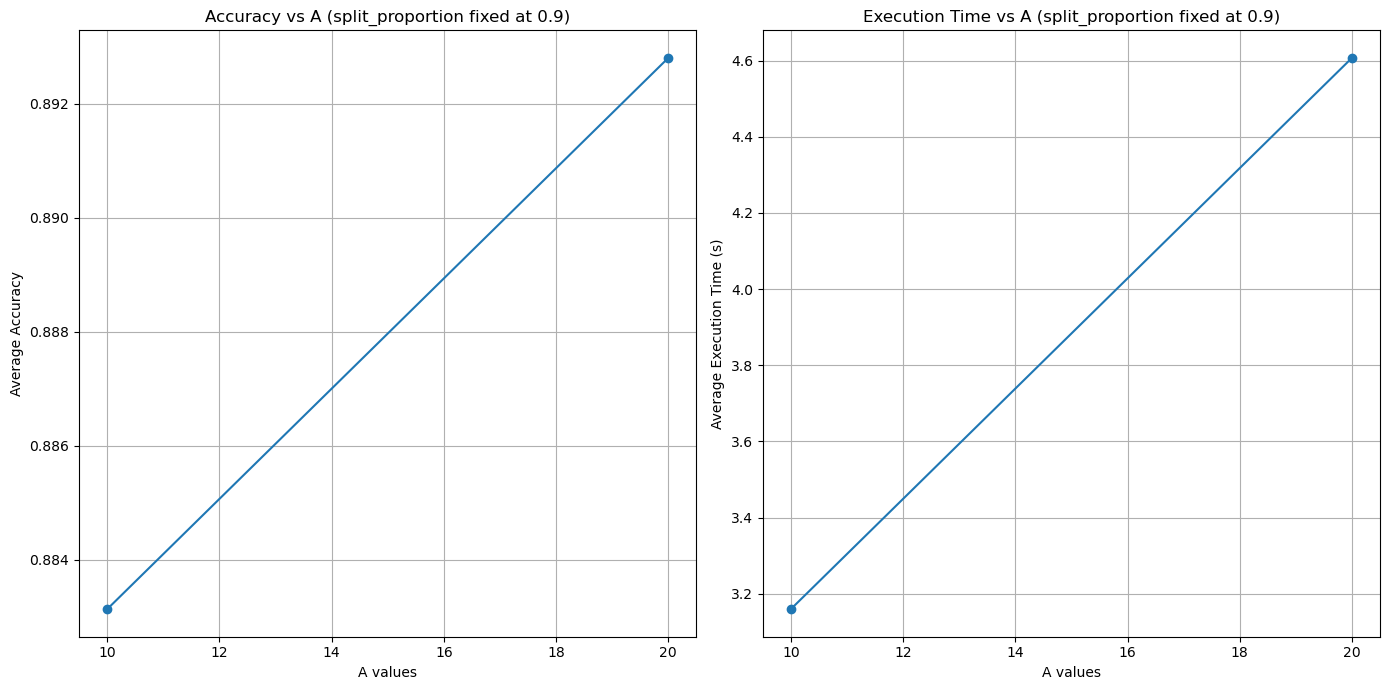

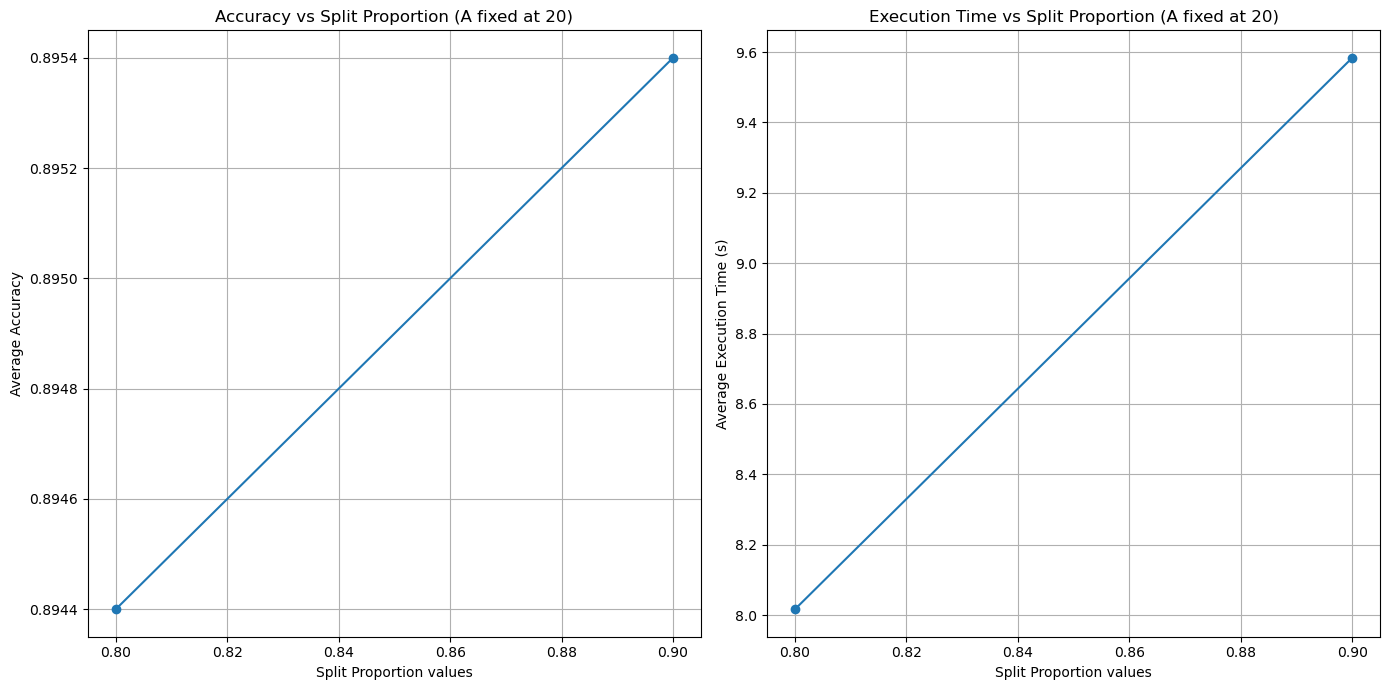

In [58]:
def graph_experimentation_for_task_1E(number_of_reps, digit):
    A_values = [10, 20, 30, 70]
    split_proportion_values = [0.8, 0.9, 0.95]
    A_fixed = 20
    split_proportion_fixed = 0.9
    T_fixed = 10  # Assuming T is fixed as it was in the previous examples

    def run_experiment(A, split_proportion):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_for_one_digit_detecting_overfitting(
                digit, A=A, verboseParam=False, split_proportion=split_proportion, iter_number=T_fixed, graph_param=True, bestAccuracyBreak= 0.90
            )
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs A with split_proportion fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(A, split_proportion_fixed)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (split_proportion fixed at 0.9)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (split_proportion fixed at 0.9)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs split_proportion with A fixed
    accuracies_split_proportion = []
    exec_times_split_proportion = []
    for split_proportion in split_proportion_values:
        avg_acc, avg_exec_time = run_experiment(A_fixed, split_proportion)
        accuracies_split_proportion.append(avg_acc)
        exec_times_split_proportion.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(split_proportion_values, accuracies_split_proportion, marker='o')
    plt.xlabel('Split Proportion values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Split Proportion (A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(split_proportion_values, exec_times_split_proportion, marker='o')
    plt.xlabel('Split Proportion values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Split Proportion (A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    digit = 5  # Example digit to test
    graph_experimentation_for_task_1E(number_of_reps, digit)


TAREA 2A: AdaboostClassifier de la librería sklearn utilizando como clasificador débil la clase 
DecisionTreeClassifier con profundidad 0.

Solución Minimalista

In [62]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, graph_param = False): # Creamos la función run_adaboost_with_sklearn
    if graph_param == False:
        print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=1, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    if graph_param == False:
        print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones




In [76]:

accuracies = run_adaboost_with_sklearn(5,T=10, A=50)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones

Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.929
Accuracies for all digits: 0.929


In [ ]:

accuracies = run_adaboost_for_all_digits_sklearn(T=50, A=20)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones


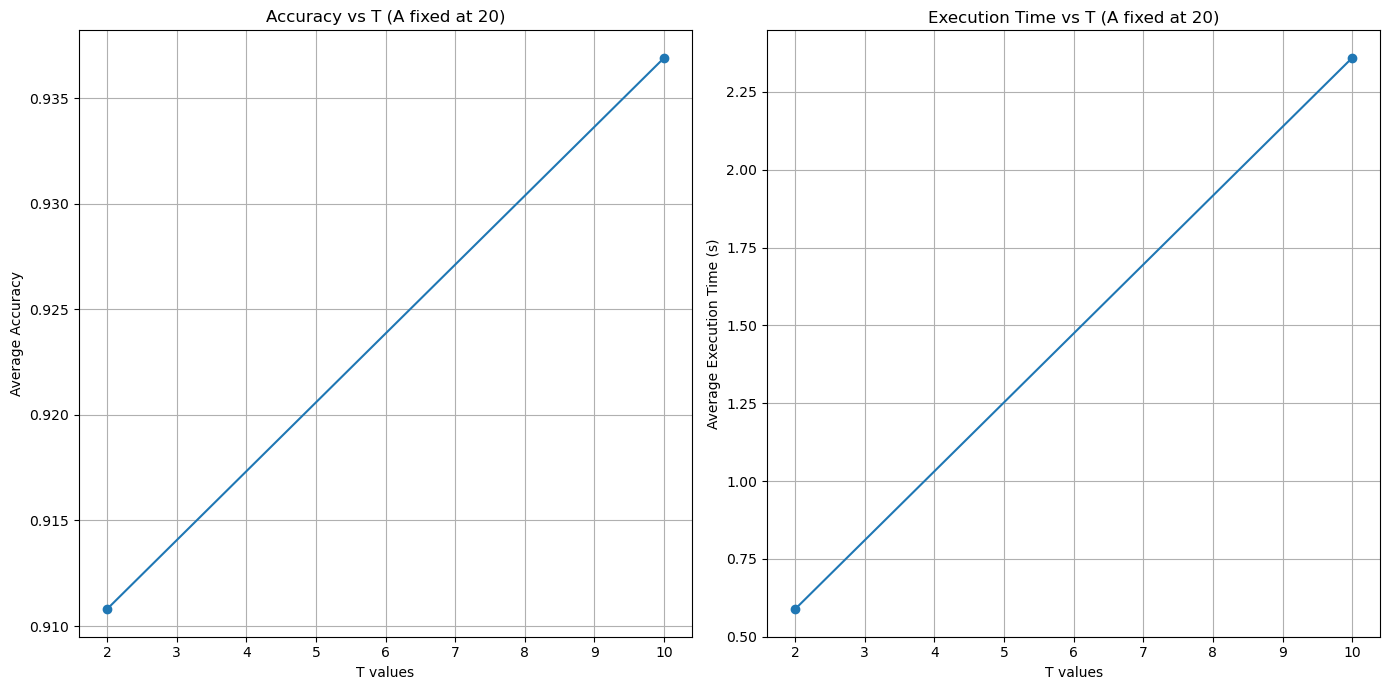

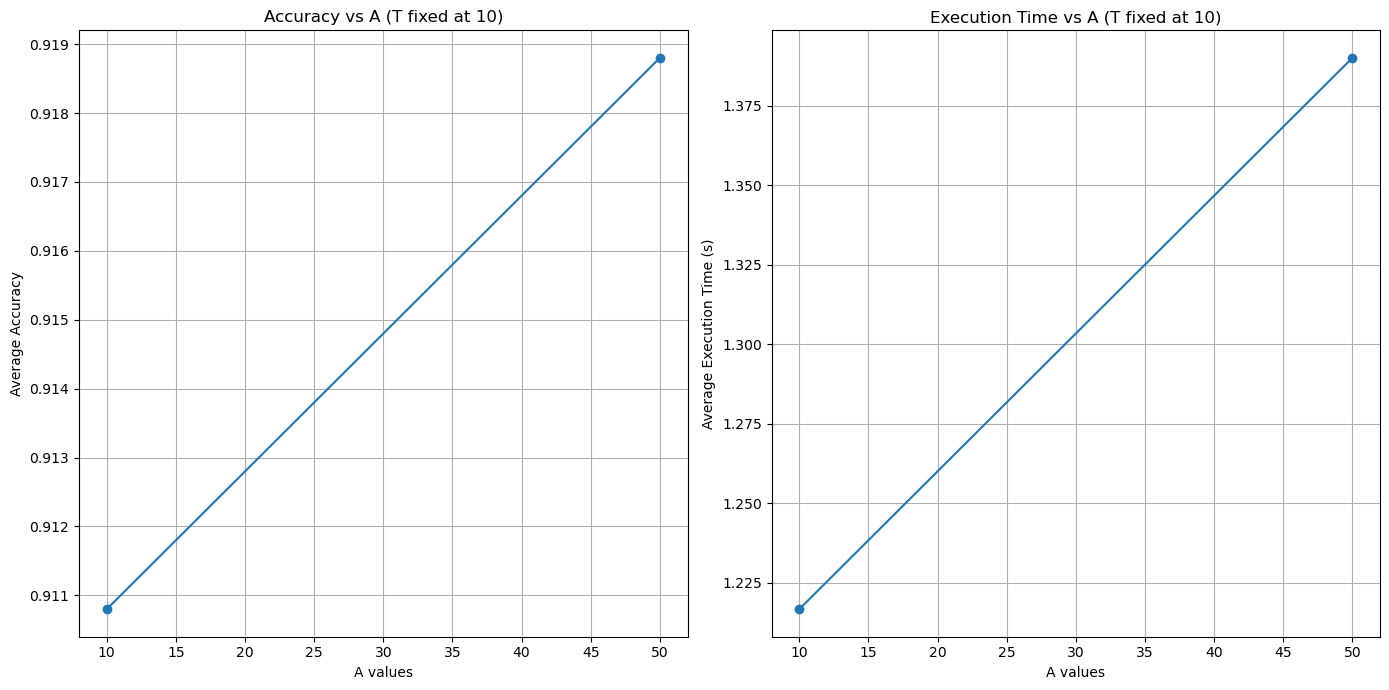

In [77]:
def graph_experimentation_for_task_2A(number_of_reps, digit):
    T_values = [5, 10, 40, 70]
    A_values = [10, 20, 30, 70]
    A_fixed = 20
    T_fixed = 5

    def run_experiment(T, A):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_with_sklearn(digit, T=T, A=A, graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 10)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 10)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    digit = 5  # You can choose any digit from 0 to 9
    graph_experimentation_for_task_2A(number_of_reps, digit)

Tarea 2B: clasificador débil árboles de decisión de 
profundidad mayor que 0

Solución Minimalista

In [82]:
import numpy as np #Importamos la librería numpy que sirve para trabajar con matrices
from tensorflow.keras.datasets import mnist # Importamos el dataset MNIST que contiene imágenes de dígitos escritos a mano
from sklearn.ensemble import AdaBoostClassifier # Importamos el clasificador AdaBoost de la librería scikit-learn que se utilizará como clasificador fuerte
from sklearn.tree import DecisionTreeClassifier # Importamos el clasificador DecisionTree de la librería scikit-learn que se utilizará como clasificador débil
from sklearn.metrics import accuracy_score # Importamos la función accuracy_score de la librería scikit-learn que se utilizará para calcular la precisión

def run_adaboost_with_sklearn(digit, T=50, A=20, max_depth = 1, graph_param = False): # Creamos la función run_adaboost_with_sklearn
    if graph_param == False:
        print(f"Running AdaBoost with sklearn for digit: {digit}") # Mostramos el dígito

    (X_train, y_train), (X_test, y_test) = mnist.load_data()  # Cargamos los datos

    X_train = X_train.reshape(X_train.shape[0], -1)  # Aplanamos los datos de entrenamiento reduciendo la dimensión a 1D
    X_test = X_test.reshape(X_test.shape[0], -1)  # Aplanamos los datos de prueba reduciendo la dimensión a 1D

    y_train_binary = np.where(y_train == digit, 1, -1)  # Convertimos las etiquetas a binarias
    y_test_binary = np.where(y_test == digit, 1, -1) # Convertimos las etiquetas a binarias


    weak_clf = DecisionTreeClassifier(max_depth=max_depth, max_features=A, random_state=42) # Creamos un clasificador débil DecisionTree con profundidad 1


    adaboost = AdaBoostClassifier(estimator=weak_clf, n_estimators=T, algorithm='SAMME', random_state=42) # Creamos el clasificador AdaBoost con el clasificador débil y el número de iteraciones

    adaboost.fit(X_train, y_train_binary) # Ajustamos el clasificador AdaBoost
    
    y_pred = adaboost.predict(X_test) # Realizamos las predicciones

    accuracy = accuracy_score(y_test_binary, y_pred) # Calculamos la precisión
    
    if graph_param == False:
        print(f"Accuracy for digit {digit} with sklearn: {accuracy}") # Mostramos la precisión

    return accuracy # Devolvemos la precisión

def run_adaboost_for_all_digits_sklearn(T=50, A=20, max_depth = 1): # Creamos la función run_adaboost_for_all_digits_sklearn
    accuracies = {} # Inicializamos las precisiones
    for digit in range(10): # Para cada dígito
        accuracy = run_adaboost_with_sklearn(digit, T, A, max_depth=max_depth) # Ejecutamos AdaBoost con sklearn
        accuracies[digit] = accuracy  # Guardamos la precisión
    return accuracies # Devolvemos las precisiones


    

In [89]:
accuracies = run_adaboost_with_sklearn(5, T=50, A=20, max_depth=2)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for one digits:", accuracies) # Imprimimos las precisiones

Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9687
Accuracies for all digits: 0.9687


In [81]:
accuracies = run_adaboost_for_all_digits_sklearn(T=5, A=20, max_depth=8)  # Ejecutamos AdaBoost con sklearn para todos los dígitos
print("Accuracies for all digits:", accuracies) # Imprimimos las precisiones

Running AdaBoost with sklearn for digit: 0
Accuracy for digit 0 with sklearn: 0.9899
Running AdaBoost with sklearn for digit: 1
Accuracy for digit 1 with sklearn: 0.9923
Running AdaBoost with sklearn for digit: 2
Accuracy for digit 2 with sklearn: 0.973
Running AdaBoost with sklearn for digit: 3
Accuracy for digit 3 with sklearn: 0.9681
Running AdaBoost with sklearn for digit: 4
Accuracy for digit 4 with sklearn: 0.9734
Running AdaBoost with sklearn for digit: 5
Accuracy for digit 5 with sklearn: 0.9675
Running AdaBoost with sklearn for digit: 6
Accuracy for digit 6 with sklearn: 0.982
Running AdaBoost with sklearn for digit: 7
Accuracy for digit 7 with sklearn: 0.9708
Running AdaBoost with sklearn for digit: 8
Accuracy for digit 8 with sklearn: 0.9646
Running AdaBoost with sklearn for digit: 9
Accuracy for digit 9 with sklearn: 0.9595
Accuracies for all digits: {0: 0.9899, 1: 0.9923, 2: 0.973, 3: 0.9681, 4: 0.9734, 5: 0.9675, 6: 0.982, 7: 0.9708, 8: 0.9646, 9: 0.9595}


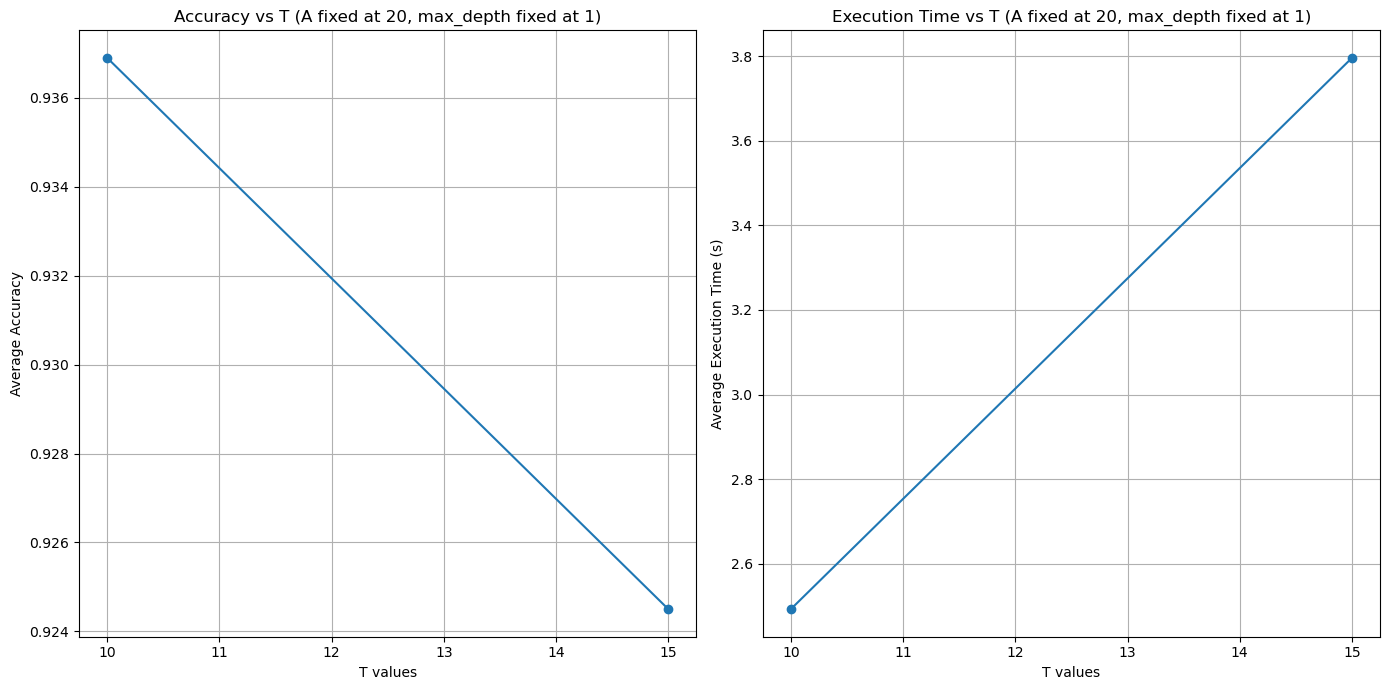

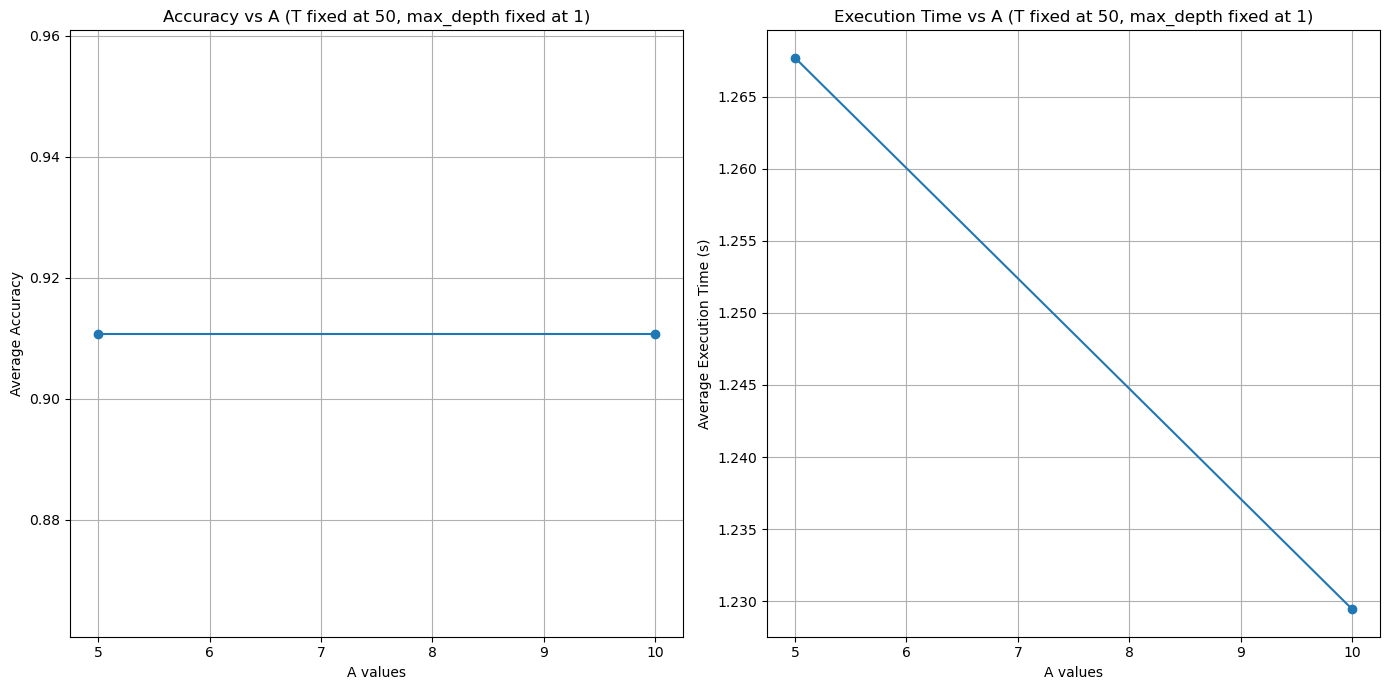

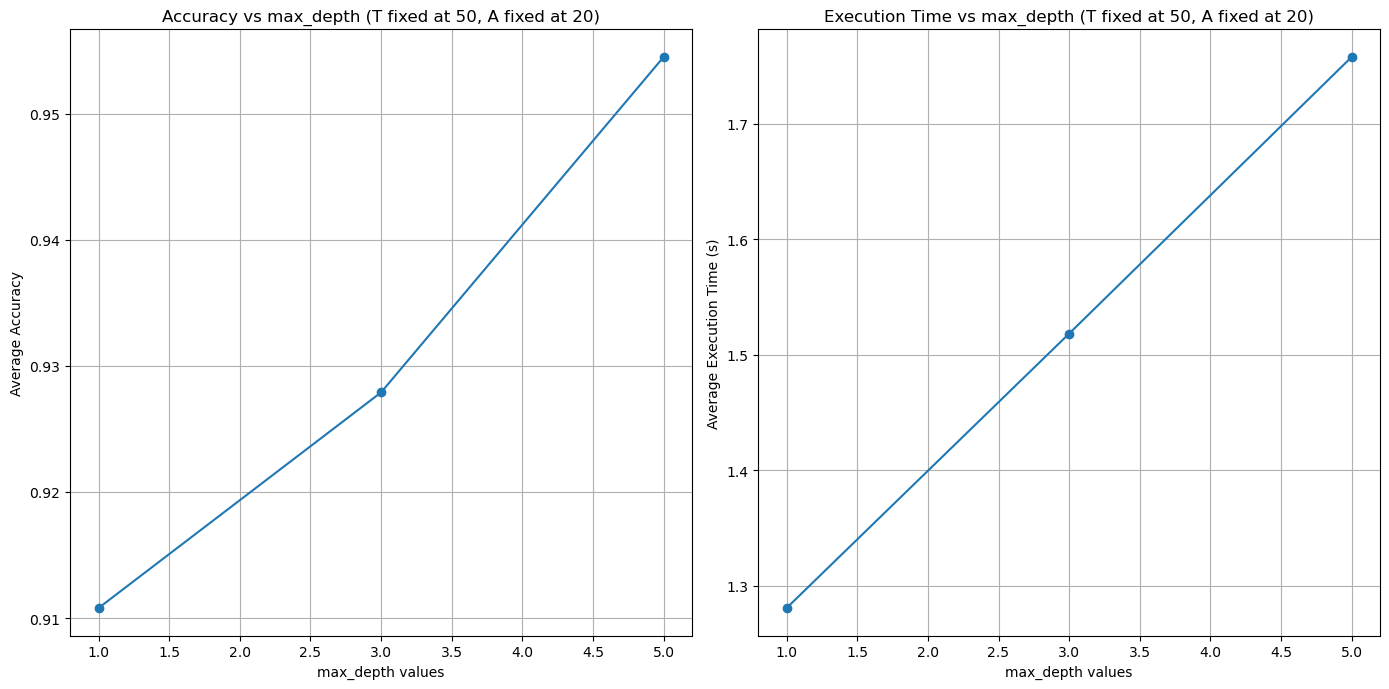

In [85]:
def graph_experimentation_for_task_2B(digit, number_of_reps):
    T_values = [5, 10, 40, 70]
    A_values = [10, 20, 30, 70]
    max_depth_values = [1, 3, 5]
    T_fixed = 5
    A_fixed = 20
    max_depth_fixed = 1

    def run_experiment(T, A, max_depth):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            accuracy = run_adaboost_with_sklearn(digit, T=T, A=A, max_depth=max_depth, graph_param=True)
            end_time = time.time()
            acc.append(accuracy)
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)

    # Accuracy vs T with A and max_depth fixed
    accuracies_T = []
    exec_times_T = []
    for T in T_values:
        avg_acc, avg_exec_time = run_experiment(T, A_fixed, max_depth_fixed)
        accuracies_T.append(avg_acc)
        exec_times_T.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(T_values, accuracies_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs T (A fixed at 20, max_depth fixed at 1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(T_values, exec_times_T, marker='o')
    plt.xlabel('T values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs T (A fixed at 20, max_depth fixed at 1)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs A with T and max_depth fixed
    accuracies_A = []
    exec_times_A = []
    for A in A_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A, max_depth_fixed)
        accuracies_A.append(avg_acc)
        exec_times_A.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(A_values, accuracies_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs A (T fixed at 50, max_depth fixed at 1)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(A_values, exec_times_A, marker='o')
    plt.xlabel('A values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs A (T fixed at 50, max_depth fixed at 1)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Accuracy vs max_depth with T and A fixed
    accuracies_depth = []
    exec_times_depth = []
    for depth in max_depth_values:
        avg_acc, avg_exec_time = run_experiment(T_fixed, A_fixed, depth)
        accuracies_depth.append(avg_acc)
        exec_times_depth.append(avg_exec_time)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(max_depth_values, accuracies_depth, marker='o')
    plt.xlabel('max_depth values')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs max_depth (T fixed at 50, A fixed at 20)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(max_depth_values, exec_times_depth, marker='o')
    plt.xlabel('max_depth values')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs max_depth (T fixed at 50, A fixed at 20)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    number_of_reps = 3
    digit = 5  # Change this to the digit you want to analyze
    graph_experimentation_for_task_2B(digit, number_of_reps)

Tarea 2C:  Utilización de la librería Keras para implementar un Multi-Layer 
Perceptron.

In [94]:
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

def load_and_preprocess_data():
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    X_train = X_train.astype('float32') / 255.0
    X_test = X_test.astype('float32') / 255.0
    
    Y_train = to_categorical(Y_train, 10)
    Y_test = to_categorical(Y_test, 10)
    
    return X_train, Y_train, X_test, Y_test

def create_mlp_model(input_shape, learning_rate, num_layers):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    
    for _ in range(num_layers):
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
    
    model.add(Dense(10, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=categorical_crossentropy, metrics=['accuracy'])
    
    return model

def main():
    X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
    
    input_shape = X_train.shape[1:]
    learning_rate = 0.001
    num_layers = 2  # Specify the number of layers here
    
    model = create_mlp_model(input_shape, learning_rate, num_layers)
    
    batch_size = 128  # Updated to match the image's batch size
    epochs = 10
    validation_split = 0.1
    
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=True, validation_data=(X_test, Y_test))
    
    score = model.evaluate(X_test, Y_test, verbose=False)
    print(f'Test loss: {score[0]:.4f}')
    print(f'Test accuracy: {score[1]: .4f}')
    




In [93]:
main()

Epoch 1/10
119/469 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7534 - loss: 0.8182

KeyboardInterrupt: 

In [95]:
def graph_experimentation_for_task_2C(number_of_reps):
    layer_values = [1, 2, 3]
    neurons_values = [128, 256, 512]
    batch_size_values = [64, 128, 256]
    learning_rate_values = [0.001, 0.01, 0.1]
    
    fixed_layers = 2
    fixed_neurons = 512
    fixed_batch_size = 128
    fixed_learning_rate = 0.001

    def run_experiment(num_layers, num_neurons, batch_size, learning_rate):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            model = create_mlp_model(input_shape, learning_rate, num_layers)
            model.fit(X_train, Y_train, batch_size=batch_size, epochs=10, verbose=False)
            score = model.evaluate(X_test, Y_test, verbose=False)
            end_time = time.time()
            acc.append(score[1])
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)
    
    # Accuracy and execution time vs number of layers
    accuracies_layers = []
    exec_times_layers = []
    for layers in layer_values:
        avg_acc, avg_exec_time = run_experiment(layers, fixed_neurons, fixed_batch_size, fixed_learning_rate)
        accuracies_layers.append(avg_acc)
        exec_times_layers.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(layer_values, accuracies_layers, marker='o')
    plt.xlabel('Number of Layers')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Number of Layers (fixed neurons, batch size, and learning rate)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(layer_values, exec_times_layers, marker='o')
    plt.xlabel('Number of Layers')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Number of Layers (fixed neurons, batch size, and learning rate)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs number of neurons
    accuracies_neurons = []
    exec_times_neurons = []
    for neurons in neurons_values:
        avg_acc, avg_exec_time = run_experiment(fixed_layers, neurons, fixed_batch_size, fixed_learning_rate)
        accuracies_neurons.append(avg_acc)
        exec_times_neurons.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(neurons_values, accuracies_neurons, marker='o')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Number of Neurons (fixed layers, batch size, and learning rate)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(neurons_values, exec_times_neurons, marker='o')
    plt.xlabel('Number of Neurons')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Number of Neurons (fixed layers, batch size, and learning rate)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs batch size
    accuracies_batch_size = []
    exec_times_batch_size = []
    for batch_size in batch_size_values:
        avg_acc, avg_exec_time = run_experiment(fixed_layers, fixed_neurons, batch_size, fixed_learning_rate)
        accuracies_batch_size.append(avg_acc)
        exec_times_batch_size.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(batch_size_values, accuracies_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Batch Size (fixed layers, neurons, and learning rate)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(batch_size_values, exec_times_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Batch Size (fixed layers, neurons, and learning rate)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs learning rate
    accuracies_lr = []
    exec_times_lr = []
    for lr in learning_rate_values:
        avg_acc, avg_exec_time = run_experiment(fixed_layers, fixed_neurons, fixed_batch_size, lr)
        accuracies_lr.append(avg_acc)
        exec_times_lr.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(learning_rate_values, accuracies_lr, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Learning Rate (fixed layers, neurons, and batch size)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(learning_rate_values, exec_times_lr, marker='o')
    plt.xlabel('Learning Rate')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Learning Rate (fixed layers, neurons, and batch size)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Changes in main
def main():
    global X_train, Y_train, X_test, Y_test, input_shape
    X_train, Y_train, X_test, Y_test = load_and_preprocess_data()
    
    input_shape = X_train.shape[1:]
    number_of_reps = 3  # or any other desired value

    graph_experimentation_for_task_2C(number_of_reps)

if __name__ == "__main__":
    main()

KeyboardInterrupt: 

Tarea 2D:  Modelado de un clasificador mediante CNN para MNIST 
con Keras

In [96]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data():
    # Load the MNIST dataset
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    
    # Reshape the data to fit the model
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
    
    # Normalize the data to the range [0, 1]
    x_train /= 255
    x_test /= 255
    
    # One-hot encode the labels
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    
    return (x_train, y_train), (x_test, y_test)

def build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128], input_shape=(28, 28, 1)):
    model = Sequential()
    
    # Add convolutional layers
    for i in range(num_conv_layers):
        if i == 0:
            # First layer needs to specify the input shape
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3), input_shape=input_shape))
        else:
            model.add(Conv2D(conv_filters[i], kernel_size=(3, 3)))
        
        # Add batch normalization
        model.add(BatchNormalization())
        # Add a LeakyReLU activation function with negative_slope
        model.add(LeakyReLU(negative_slope=0.1))
        # Add a max pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # Add a dropout layer to prevent overfitting
        model.add(Dropout(0.25))
    
    # Flatten the layer
    model.add(Flatten())
    
    # Add dense layers
    for units in dense_units:
        model.add(Dense(units))
        model.add(BatchNormalization())
        model.add(LeakyReLU(negative_slope=0.1))
        model.add(Dropout(0.5))
    
    # Add the output layer with 10 units and softmax activation function
    model.add(Dense(10, activation='softmax'))
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    # Train the model
    model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_test, y_test))
    
    # Evaluate the model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss: {:.4f}'.format(score[0]))
    print('Test accuracy: {:.4f}'.format(score[1]))

def execute_CNN():
    # Load and preprocess the data
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()

    # Build the CNN model
    model = build_cnn_model(num_conv_layers=2, num_dense_layers=1, conv_filters=[32, 64], dense_units=[128])

    # Train and evaluate the model
    train_and_evaluate_model(model, x_train, y_train, x_test, y_test)


In [97]:
execute_CNN()

c:\Users\Crislt\anaconda3\envs\SIPrac2Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.8317 - loss: 0.5480 - val_accuracy: 0.7201 - val_loss: 0.9016
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9650 - loss: 0.1192 - val_accuracy: 0.9849 - val_loss: 0.0448
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.9735 - loss: 0.0878 - val_accuracy: 0.9846 - val_loss: 0.0452
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9777 - loss: 0.0709 - val_accuracy: 0.9890 - val_loss: 0.0326
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9816 - loss: 0.0593 - val_accuracy: 0.9904 - val_loss: 0.0299
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9816 - loss: 0.0580 - val_accuracy: 0.9907 - val_loss: 0.0270
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.9840 - loss: 0.0508 - val_accuracy: 0.9909 - val_loss: 0.0273
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.9867 - loss: 0.0437 - 

In [98]:
def graph_experimentation_for_task_2D(number_of_reps):
    conv_layer_values = [1, 2, 3]
    dense_layer_values = [1, 2, 3]
    batch_size_values = [64, 128, 256]
    epoch_values = [5, 10, 20]
    
    fixed_conv_layers = 2
    fixed_dense_layers = 1
    fixed_batch_size = 128
    fixed_epochs = 10
    
    conv_filters = [32, 64]
    dense_units = [128]
    
    def run_experiment(num_conv_layers, num_dense_layers, batch_size, epochs):
        acc = []
        exec_time = []
        for _ in range(number_of_reps):
            start_time = time.time()
            model = build_cnn_model(num_conv_layers=num_conv_layers, num_dense_layers=num_dense_layers, 
                                    conv_filters=conv_filters[:num_conv_layers], dense_units=dense_units[:num_dense_layers])
            model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(x_test, y_test))
            score = model.evaluate(x_test, y_test, verbose=0)
            end_time = time.time()
            acc.append(score[1])
            exec_time.append(end_time - start_time)
        return np.mean(acc), np.mean(exec_time)
    
    # Accuracy and execution time vs num_conv_layers
    accuracies_conv_layers = []
    exec_times_conv_layers = []
    for layers in conv_layer_values:
        avg_acc, avg_exec_time = run_experiment(layers, fixed_dense_layers, fixed_batch_size, fixed_epochs)
        accuracies_conv_layers.append(avg_acc)
        exec_times_conv_layers.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(conv_layer_values, accuracies_conv_layers, marker='o')
    plt.xlabel('Number of Convolutional Layers')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Number of Convolutional Layers (fixed dense layers, batch size, and epochs)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(conv_layer_values, exec_times_conv_layers, marker='o')
    plt.xlabel('Number of Convolutional Layers')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Number of Convolutional Layers (fixed dense layers, batch size, and epochs)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs num_dense_layers
    accuracies_dense_layers = []
    exec_times_dense_layers = []
    for layers in dense_layer_values:
        avg_acc, avg_exec_time = run_experiment(fixed_conv_layers, layers, fixed_batch_size, fixed_epochs)
        accuracies_dense_layers.append(avg_acc)
        exec_times_dense_layers.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(dense_layer_values, accuracies_dense_layers, marker='o')
    plt.xlabel('Number of Dense Layers')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Number of Dense Layers (fixed conv layers, batch size, and epochs)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(dense_layer_values, exec_times_dense_layers, marker='o')
    plt.xlabel('Number of Dense Layers')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Number of Dense Layers (fixed conv layers, batch size, and epochs)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs batch_size
    accuracies_batch_size = []
    exec_times_batch_size = []
    for batch_size in batch_size_values:
        avg_acc, avg_exec_time = run_experiment(fixed_conv_layers, fixed_dense_layers, batch_size, fixed_epochs)
        accuracies_batch_size.append(avg_acc)
        exec_times_batch_size.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(batch_size_values, accuracies_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Batch Size (fixed conv layers, dense layers, and epochs)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(batch_size_values, exec_times_batch_size, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Batch Size (fixed conv layers, dense layers, and epochs)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Accuracy and execution time vs epochs
    accuracies_epochs = []
    exec_times_epochs = []
    for epochs in epoch_values:
        avg_acc, avg_exec_time = run_experiment(fixed_conv_layers, fixed_dense_layers, fixed_batch_size, epochs)
        accuracies_epochs.append(avg_acc)
        exec_times_epochs.append(avg_exec_time)
    
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epoch_values, accuracies_epochs, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.title('Accuracy vs Epochs (fixed conv layers, dense layers, and batch size)')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_values, exec_times_epochs, marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Average Execution Time (s)')
    plt.title('Execution Time vs Epochs (fixed conv layers, dense layers, and batch size)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Changes in main
def main():
    global x_train, y_train, x_test, y_test
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
    
    number_of_reps = 3  # or any other desired value

    graph_experimentation_for_task_2D(number_of_reps)

if __name__ == "__main__":
    main()

KeyboardInterrupt: 